# Propensity Matching

In this notebook, we utilize propensity matching methdos on our dataset to estimate the effect size of our outcomes. We use a two step analysis. First, we propensity match on each individual city. Then, we use a random effects model to calculate a pooled effect size.

We additionally do our pretreatment covariate selection individually on each city.

### Helpers

In [1]:
from sklearn.tree import DecisionTreeClassifier
from psmpy import PsmPy
from psmpy.plotting import *
from psmpy.functions import cohenD

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from warnings import warn

import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

import osmnx as ox

from propensity_helpers import *

In [2]:
# Columns NOT to match on
EXCLUDE_LIST = ['YEAR', 'STATE', 'STATEA', 
                'COUNTY', 'COUNTYA', 'TRACTA', 
                'geometry', 'AREANAM',
                'n_311s', 'n_crashes', 'whiteP', 
                'nonWhtP', 'blackP'] # let's try on num_crashes first

# Constant for propensity calculation
PROP_BALANCE = False

# Constants for KNN matching
CALIPER = 0.2
DROP_UNMATCHED = True
KNN_WITH_REPLACEMENT = True
PROP_MATCHER = 'propensity_logit'
N_FEATURES = 15

### Analysis

In [3]:
df = gpd.read_file('../../data/shapes/census_final_fixed.shp')
df.sample(5, random_state=5)

,GISJOIN,YEAR,STATE,STATEA,COUNTY,COUNTYA,TRACTA,AREANAM,whiteP,nonWhtP,...,rfrgNRp,htCntrl,htNCntr,htNRprt,grade,n_crashes,n_311s,nyn,treatment_,geometry
2470,G42010100035ZZ,1940.0,Pennsylvania,42,Philadelphia,101,0035,STCTY-42101 TRACT- 0035-ZZ IN PHILADELPHIA PA,99.86,0.14,...,2.0,860.0,0.0,0.0,B,184.0,423.0,False,B,"POLYGON ((1755933.098 478263.583, 1755927.076 ..."
2395,G42010100032C,1940.0,Pennsylvania,42,Philadelphia,101,0032,STCTY-42101 TRACT- 0032-C IN PHILADELPHIA PA,47.93,52.07,...,41.0,3201.0,10.0,0.0,D,221.0,819.0,True,D_black,"POLYGON ((1750117.078 470663.751, 1750021.283 ..."
1036,G17003100537,1940.0,Illinois,17,Cook,031,0537,STCTY-17031 TRACT- 0537 IN CHICAGO IL,9.26,90.74,...,0.0,1.0,118.0,0.0,D,88.0,46.0,True,D_black,"POLYGON ((689375.29 515595.468, 689371.449 515..."
2509,G42010100040L,1940.0,Pennsylvania,42,Philadelphia,101,0040,STCTY-42101 TRACT- 0040-L IN PHILADELPHIA PA,99.92,0.08,...,45.0,3505.0,18.0,0.0,C,261.0,1444.0,False,C,"POLYGON ((1746055.545 462965.492, 1746043.234 ..."
1109,G17003100610,1940.0,Illinois,17,Cook,031,0610,STCTY-17031 TRACT- 0610 IN CHICAGO IL,99.48,0.52,...,2.0,733.0,0.0,0.0,C,67.0,71.0,False,C,"POLYGON ((692774.651 512527.311, 692748.147 51..."


In [4]:
# Split df by cities -- thankfully we can just split on state.
# compare non-black AB to black CD; requires dropping some rows
#mask = df.treatment_.isin(['A', 'B', 'C_black', 'D_black'])
#df_rel = df.copy()[mask].reset_index(drop=True)

df_rel = df.copy()

regrade_mapper = dict(A=0, B=0, C=0, D=0, B_black=1, C_black=1, D_black=1)

# Fix df.grade if needed
if not df_rel.treatment_[0] in [0, 1]:
     df_rel['treatment_'] = df_rel.treatment_.apply(lambda x: regrade_mapper[x])

df_rel = df_rel.drop(columns=['grade', 'nyn'])

# Subset down to cities
chicago = df_rel.copy()[df_rel.STATE == 'Illinois']
newyork = df_rel.copy()[df_rel.STATE == 'New York']
philidelphia = df_rel.copy()[df_rel.STATE == 'Pennsylvania']
losangeles = df_rel.copy()[df_rel.STATE == 'California']
detroit = df_rel.copy()[df_rel.STATE == 'Michigan']

In [5]:
# Ensure boundaries are right
chicago = enforce_administrative_boundaries(chicago, "Chicago, Illinois")
newyork = enforce_administrative_boundaries(newyork, "New York, New York")
philidelphia = enforce_administrative_boundaries(philidelphia, "Philadelphia, Pennsylvania")
losangeles = enforce_administrative_boundaries(losangeles, 'Los Angeles, California')
detroit = enforce_administrative_boundaries(detroit, 'Detroit, Michigan')

How many tracts do we have after this?

In [6]:
n_tracts = sum((chicago.shape[0], newyork.shape[0], philidelphia.shape[0], losangeles.shape[0], detroit.shape[0]))
print(n_tracts)

2402


In [7]:
sum((chicago.n_crashes.sum(), newyork.n_crashes.sum(), philidelphia.n_crashes.sum(), losangeles.n_crashes.sum(), detroit.n_crashes.sum()))

1544559.0

In [8]:
sum((chicago.n_311s.sum(), newyork.n_311s.sum(), philidelphia.n_311s.sum(), losangeles.n_311s.sum(), detroit.n_311s.sum()))

3287583.0

Okay cool so we had a good few superfluous tracts. Also, scary!

## Setup

In [9]:
driving_covariates = dict(covariates=[], city=[])

all_results = {
    'city': [],
    '311_coef': [],
    '311_se': [],
    '311_p': [],
    'crash_coef': [],
    'crash_se': [],
    'crash_p': []
}

## Chicago 

In [10]:
covariates_chicago = feature_selection(chicago)

driving_covariates['city'].append('Chicago')
driving_covariates['covariates'].append(covariates_chicago)

chicago_psmpy = make_psmpy(chicago[covariates_chicago + ['n_crashes', 'treatment_', 'GISJOIN']], treatment='treatment_',
                 outcome='n_crashes')

chicago_psmpy.logistic_ps(balance=PROP_BALANCE)

chicago_psmpy.knn_matched(matcher=PROP_MATCHER, 
                          replacement=KNN_WITH_REPLACEMENT, caliper=CALIPER,
                          drop_unmatched=DROP_UNMATCHED)

Classifier scored a 1.0 on full dataset


c:\Users\wimer\github\personal\thesis\notebooks\result_notebooks\propensity_helpers.py:98: UserWarning: Found NAs in covariates, dropping. Lost 14 observations out of 921
  warn(f"Found NAs in covariates, dropping. Lost {old_size-new_size} observations out of {old_size}")
c:\Python311\Lib\site-packages\psmpy\psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False')


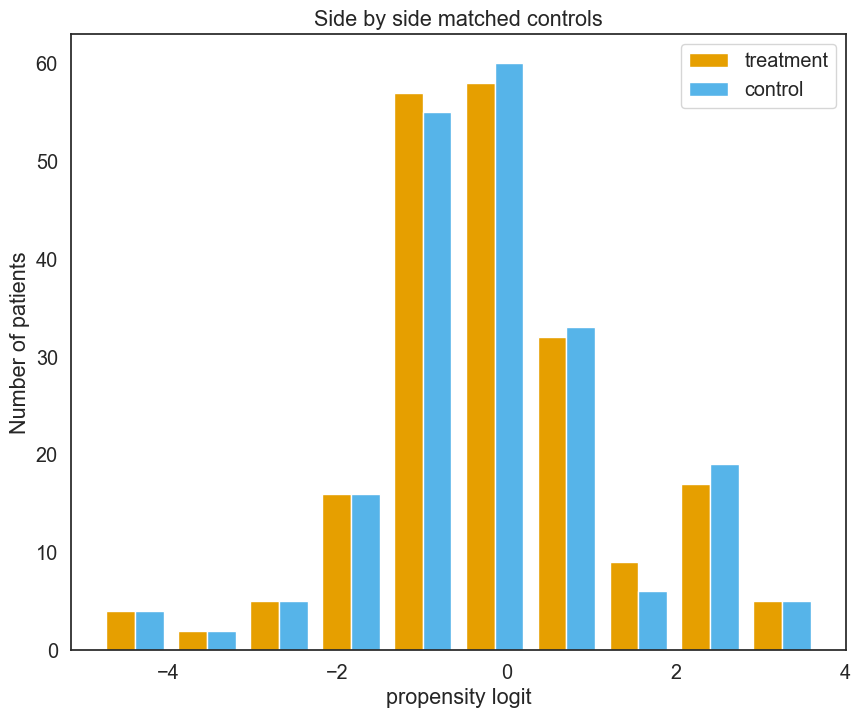

In [11]:
chicago_psmpy.plot_match()

c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


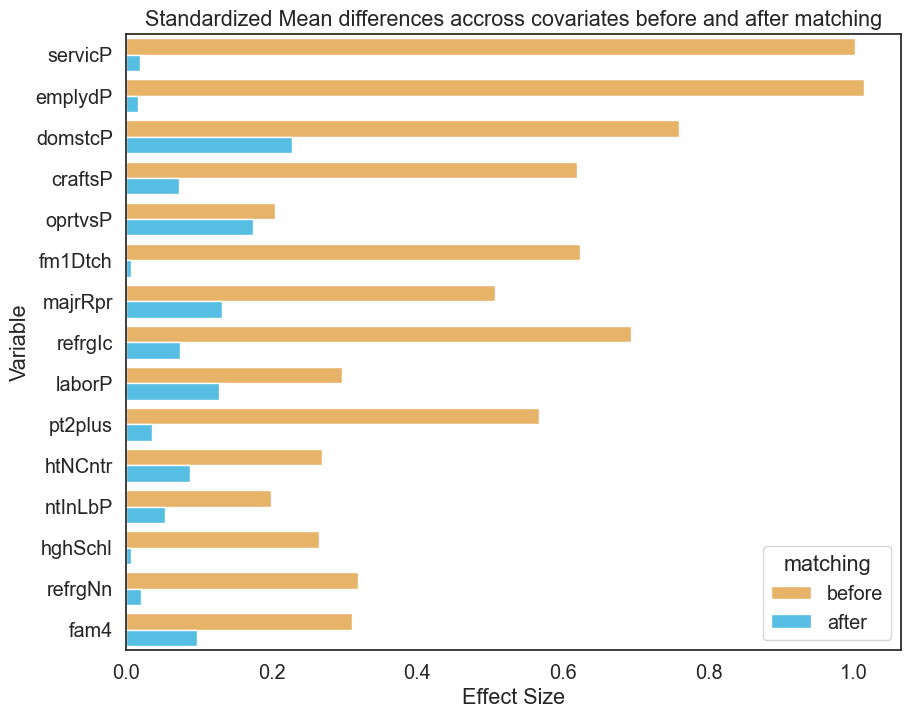

In [12]:
chicago_psmpy.effect_size_plot()

In [13]:
chicago_matched = retrieve_matches(chicago_psmpy, chicago, treatment='treatment_')
chicago_matched['log_exposure'] = np.log(5)

run_models_update_results(chicago_matched, all_results, 'Chicago')

Estimating an alpha of 1.5167649879690748 for crashes
Checking Asumptions of Negative Binomial Model for 311s:
    	Mean 311s: 677.2312312312313
    	Variance of 311s: 601540.8048048049
    
Estimating an alpha of 1.3100923801866797 for 311s
                 Generalized Linear Model Regression Results                  
Dep. Variable:              n_crashes   No. Observations:                  333
Model:                            GLM   Df Residuals:                      331
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2420.9
Date:                Wed, 26 Mar 2025   Deviance:                       175.74
Time:                        13:36:25   Pearson chi2:                     244.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04551
Covariance Type:            nonrobust          

In [14]:
all_results

{'city': ['Chicago'],
 '311_coef': [-0.5144953028512312],
 '311_se': [0.12900983127041088],
 '311_p': [6.662374951876087e-05],
 'crash_coef': [-0.538611323577101],
 'crash_se': [0.1388276975048072],
 'crash_p': [0.00010458071388452409]}

## New York City

In [15]:
covariates_nyc = feature_selection(newyork)

driving_covariates['city'].append('New York City')
driving_covariates['covariates'].append(covariates_nyc)

newyork_psmpy = make_psmpy(newyork[covariates_nyc + ['n_crashes', 'treatment_', 'GISJOIN']], treatment='treatment_',
                           outcome='n_crashes')

newyork_psmpy.logistic_ps(balance=PROP_BALANCE)

newyork_psmpy.knn_matched(matcher=PROP_MATCHER, 
                          replacement=KNN_WITH_REPLACEMENT, caliper=CALIPER,
                          drop_unmatched=DROP_UNMATCHED)

Classifier scored a 1.0 on full dataset


c:\Python311\Lib\site-packages\psmpy\psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False')


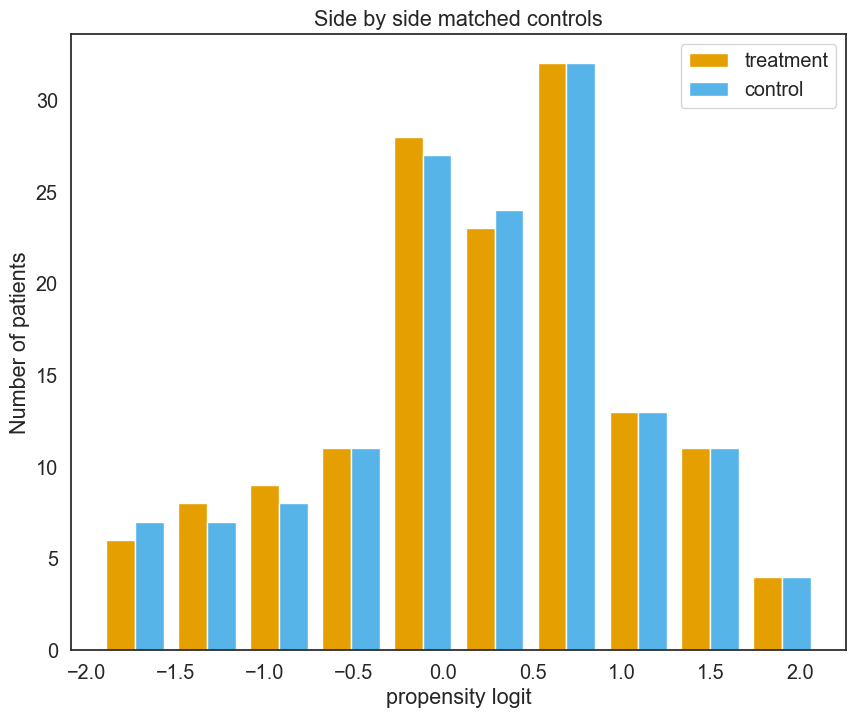

In [16]:
newyork_psmpy.plot_match()

c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


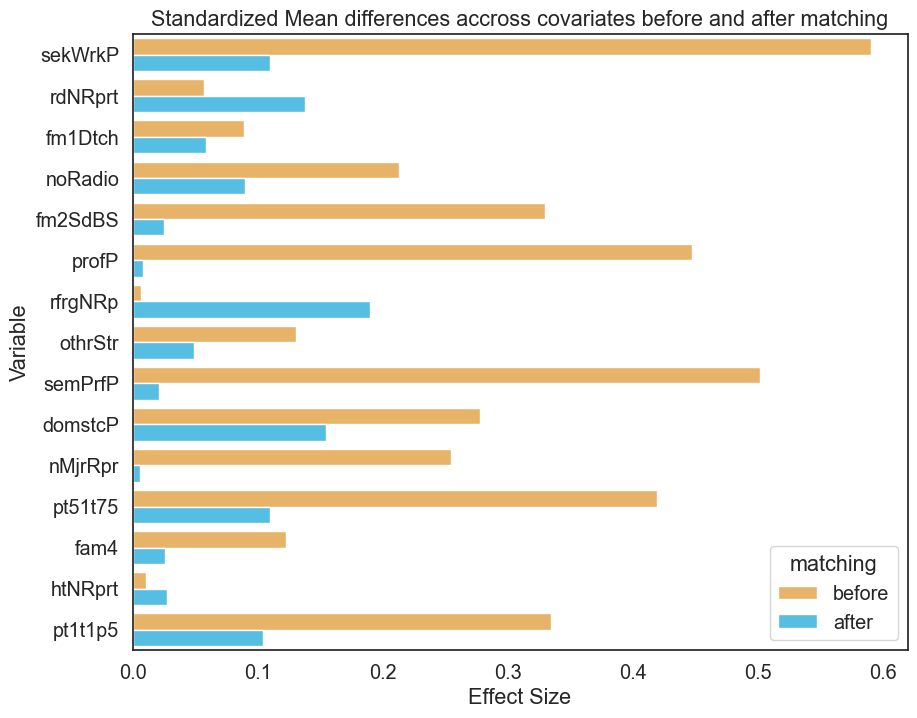

In [17]:
newyork_psmpy.effect_size_plot()

In [18]:
newyork_matched = retrieve_matches(newyork_psmpy, newyork)
newyork_matched['log_exposure'] = np.log(5)

run_models_update_results(newyork_matched, all_results, 'New York')

all_results

Estimating an alpha of 0.5378737779293297 for crashes
Checking Asumptions of Negative Binomial Model for 311s:
    	Mean 311s: 961.2576419213974
    	Variance of 311s: 714210.4640312571
    
Estimating an alpha of 0.7719011469594628 for 311s
                 Generalized Linear Model Regression Results                  
Dep. Variable:              n_crashes   No. Observations:                  229
Model:                            GLM   Df Residuals:                      227
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1943.7
Date:                Wed, 26 Mar 2025   Deviance:                       196.70
Time:                        13:36:26   Pearson chi2:                     226.
No. Iterations:                     5   Pseudo R-squ. (CS):           0.006289
Covariance Type:            nonrobust          

{'city': ['Chicago', 'New York'],
 '311_coef': [-0.5144953028512312, -0.11813767059840824],
 '311_se': [0.12900983127041088, 0.12054779494742558],
 '311_p': [6.662374951876087e-05, 0.3270827136371298],
 'crash_coef': [-0.538611323577101, 0.12161877420118983],
 'crash_se': [0.1388276975048072, 0.10060879100248632],
 'crash_p': [0.00010458071388452409, 0.22672873878913957]}

## Detroit

In [19]:
covariates_detroit = feature_selection(detroit)

driving_covariates['city'].append('Detroit')
driving_covariates['covariates'].append(covariates_detroit)

detroit_psmpy = make_psmpy(detroit[covariates_detroit + ['n_crashes', 'treatment_', 'GISJOIN']],
                           treatment='treatment_', outcome='n_crashes')

detroit_psmpy.logistic_ps(balance=PROP_BALANCE)
detroit_psmpy.knn_matched(matcher=PROP_MATCHER,
                          replacement=KNN_WITH_REPLACEMENT, caliper=CALIPER,
                          drop_unmatched=DROP_UNMATCHED)

Classifier scored a 1.0 on full dataset


c:\Users\wimer\github\personal\thesis\notebooks\result_notebooks\propensity_helpers.py:98: UserWarning: Found NAs in covariates, dropping. Lost 1 observations out of 419
  warn(f"Found NAs in covariates, dropping. Lost {old_size-new_size} observations out of {old_size}")
c:\Users\wimer\github\personal\thesis\notebooks\result_notebooks\propensity_helpers.py:102: UserWarning: Found missing outcome values. Filling with 0
  warn("Found missing outcome values. Filling with 0")
c:\Python311\Lib\site-packages\psmpy\psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatche

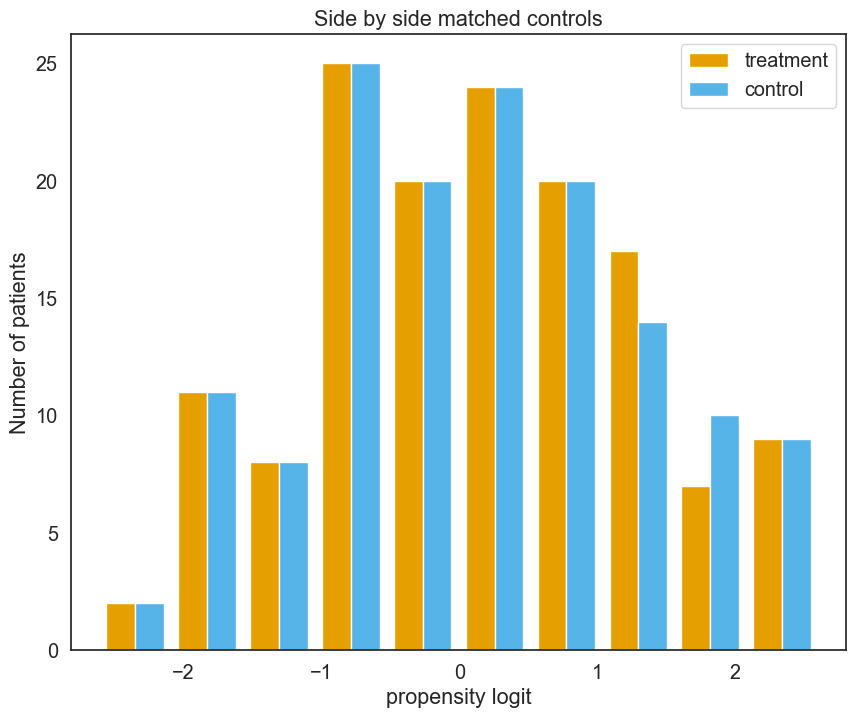

In [20]:
detroit_psmpy.plot_match()

c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


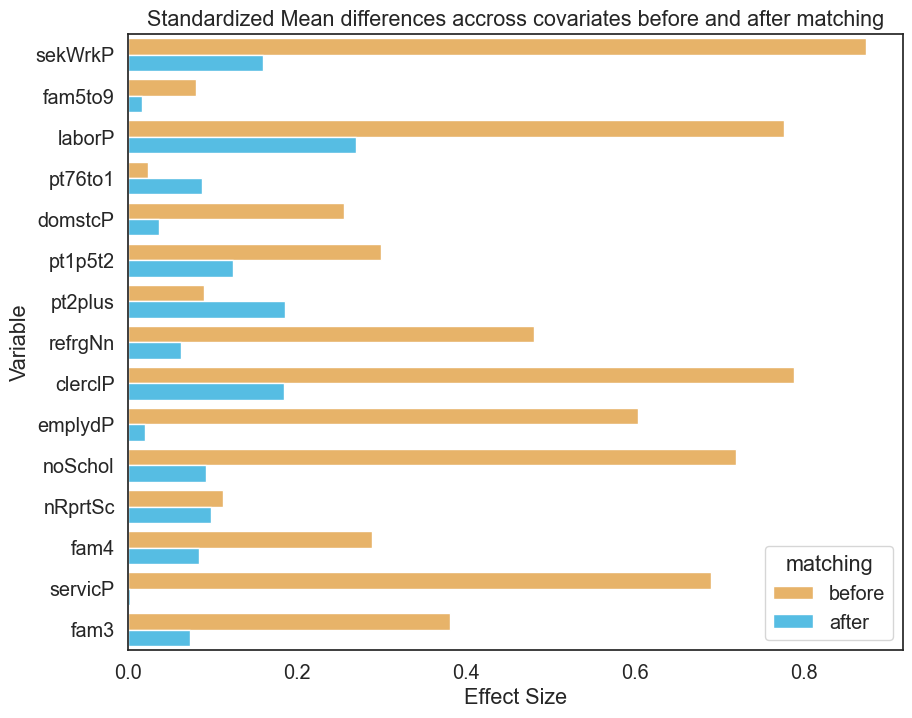

In [21]:
detroit_psmpy.effect_size_plot()

In [22]:
detroit_matched = retrieve_matches(detroit_psmpy, detroit)
detroit_matched['log_exposure'] = np.log(5)

run_models_update_results(detroit_matched, all_results, 'Detroit')

all_results

Estimating an alpha of 1.3933228062413712 for crashes
Checking Asumptions of Negative Binomial Model for 311s:
    	Mean 311s: 10.385474860335195
    	Variance of 311s: 133.74383277885883
    
Estimating an alpha of 1.1437098517186837 for 311s
                 Generalized Linear Model Regression Results                  
Dep. Variable:              n_crashes   No. Observations:                  202
Model:                            GLM   Df Residuals:                      200
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1302.2
Date:                Wed, 26 Mar 2025   Deviance:                       151.72
Time:                        13:36:28   Pearson chi2:                     175.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01804
Covariance Type:            nonrobust        

{'city': ['Chicago', 'New York', 'Detroit'],
 '311_coef': [-0.5144953028512312, -0.11813767059840824, -0.3781086515424992],
 '311_se': [0.12900983127041088, 0.12054779494742558, 0.17376580706319023],
 '311_p': [6.662374951876087e-05, 0.3270827136371298, 0.029557732659284505],
 'crash_coef': [-0.538611323577101, 0.12161877420118983, -0.32940530543981733],
 'crash_se': [0.1388276975048072, 0.10060879100248632, 0.17421438776620551],
 'crash_p': [0.00010458071388452409, 0.22672873878913957, 0.05865047915985967]}

## Los Angeles

In [23]:
covariates_la = feature_selection(losangeles)

driving_covariates['city'].append('Los Angeles')
driving_covariates['covariates'].append(covariates_la)

losangeles_psmpy = make_psmpy(losangeles[covariates_la + ['n_crashes', 'treatment_', 'GISJOIN']], 
                              treatment='treatment_', outcome='n_crashes')

losangeles_psmpy.logistic_ps(balance=PROP_BALANCE)

losangeles_psmpy.knn_matched(matcher=PROP_MATCHER, 
                          replacement=KNN_WITH_REPLACEMENT, caliper=CALIPER,
                          drop_unmatched=DROP_UNMATCHED)

Classifier scored a 1.0 on full dataset


c:\Users\wimer\github\personal\thesis\notebooks\result_notebooks\propensity_helpers.py:98: UserWarning: Found NAs in covariates, dropping. Lost 1 observations out of 352
  warn(f"Found NAs in covariates, dropping. Lost {old_size-new_size} observations out of {old_size}")
c:\Users\wimer\github\personal\thesis\notebooks\result_notebooks\propensity_helpers.py:102: UserWarning: Found missing outcome values. Filling with 0
  warn("Found missing outcome values. Filling with 0")
c:\Python311\Lib\site-packages\psmpy\psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatche

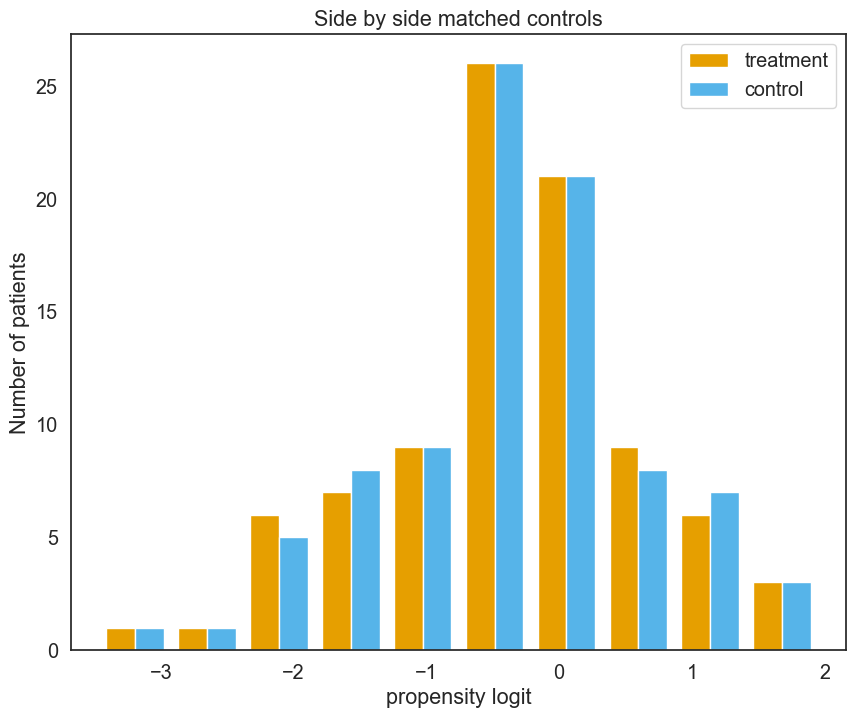

In [24]:
losangeles_psmpy.plot_match()

c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


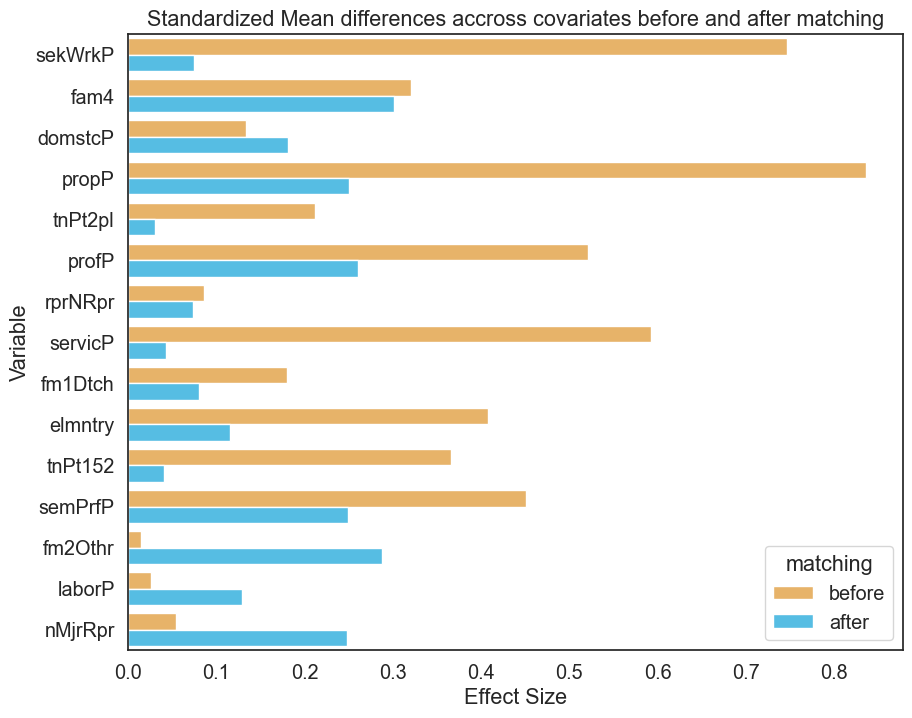

In [25]:
losangeles_psmpy.effect_size_plot()

In [26]:
losangeles_matched = retrieve_matches(losangeles_psmpy, losangeles)
losangeles_matched['log_exposure'] = np.log(5)

run_models_update_results(losangeles_matched, all_results, 'Los Angeles')

all_results

Estimating an alpha of 0.5255518024841086 for crashes
Checking Asumptions of Negative Binomial Model for 311s:
    	Mean 311s: 5702.528571428571
    	Variance of 311s: 18336856.581911612
    
Estimating an alpha of 0.5637088685252484 for 311s
                 Generalized Linear Model Regression Results                  
Dep. Variable:              n_crashes   No. Observations:                  141
Model:                            GLM   Df Residuals:                      139
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -976.26
Date:                Wed, 26 Mar 2025   Deviance:                       184.78
Time:                        13:36:29   Pearson chi2:                     145.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.03538
Covariance Type:            nonrobust         

{'city': ['Chicago', 'New York', 'Detroit', 'Los Angeles'],
 '311_coef': [-0.5144953028512312,
  -0.11813767059840824,
  -0.3781086515424992,
  0.4634894926561044],
 '311_se': [0.12900983127041088,
  0.12054779494742558,
  0.17376580706319023,
  0.13188386541146815],
 '311_p': [6.662374951876087e-05,
  0.3270827136371298,
  0.029557732659284505,
  0.00044078839486135077],
 'crash_coef': [-0.538611323577101,
  0.12161877420118983,
  -0.32940530543981733,
  0.28737826492319646],
 'crash_se': [0.1388276975048072,
  0.10060879100248632,
  0.17421438776620551,
  0.1259207274202303],
 'crash_p': [0.00010458071388452409,
  0.22672873878913957,
  0.05865047915985967,
  0.022476606826386004]}

## Philadelphia

In [27]:
covariates_phili = feature_selection(philidelphia)

driving_covariates['city'].append('Philadelphia')
driving_covariates['covariates'].append(covariates_phili)

philidelphia_psmpy = make_psmpy(philidelphia[covariates_phili + ['n_crashes', 'treatment_', 'GISJOIN']], 
                                treatment='treatment_', outcome='n_crashes')

philidelphia_psmpy.logistic_ps(balance=PROP_BALANCE)

philidelphia_psmpy.knn_matched(matcher=PROP_MATCHER, 
                          replacement=KNN_WITH_REPLACEMENT, caliper=CALIPER,
                          drop_unmatched=DROP_UNMATCHED)

Classifier scored a 1.0 on full dataset


c:\Users\wimer\github\personal\thesis\notebooks\result_notebooks\propensity_helpers.py:98: UserWarning: Found NAs in covariates, dropping. Lost 4 observations out of 369
  warn(f"Found NAs in covariates, dropping. Lost {old_size-new_size} observations out of {old_size}")
c:\Users\wimer\github\personal\thesis\notebooks\result_notebooks\propensity_helpers.py:102: UserWarning: Found missing outcome values. Filling with 0
  warn("Found missing outcome values. Filling with 0")
c:\Python311\Lib\site-packages\psmpy\psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatche

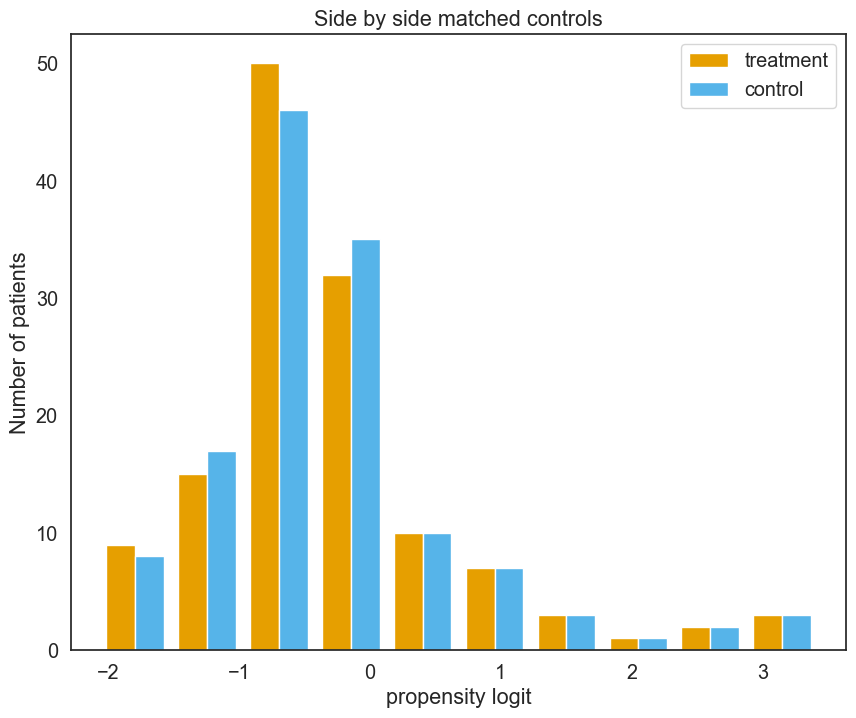

In [28]:
philidelphia_psmpy.plot_match()

c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


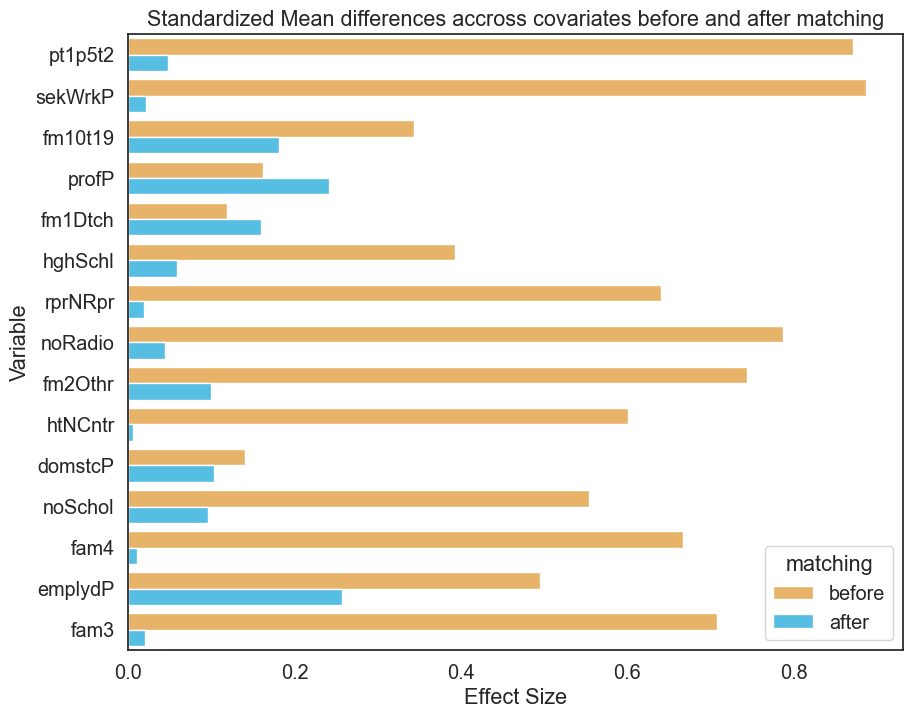

In [29]:
philidelphia_psmpy.effect_size_plot()

In [30]:
philidelphia_matched = retrieve_matches(philidelphia_psmpy, philidelphia)
philidelphia_matched['log_exposure'] = np.log(5)

run_models_update_results(philidelphia_matched, all_results, 'Philidelphia')

all_results

Estimating an alpha of 0.6142150427532675 for crashes
Checking Asumptions of Negative Binomial Model for 311s:
    	Mean 311s: 504.484375
    	Variance of 311s: 301003.6751472513
    
Estimating an alpha of 1.1807225763504345 for 311s
                 Generalized Linear Model Regression Results                  
Dep. Variable:              n_crashes   No. Observations:                  191
Model:                            GLM   Df Residuals:                      189
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1040.3
Date:                Wed, 26 Mar 2025   Deviance:                       234.83
Time:                        13:36:30   Pearson chi2:                     190.
No. Iterations:                     5   Pseudo R-squ. (CS):          9.324e-07
Covariance Type:            nonrobust                 

{'city': ['Chicago', 'New York', 'Detroit', 'Los Angeles', 'Philidelphia'],
 '311_coef': [-0.5144953028512312,
  -0.11813767059840824,
  -0.3781086515424992,
  0.4634894926561044,
  0.09447381330352905],
 '311_se': [0.12900983127041088,
  0.12054779494742558,
  0.17376580706319023,
  0.13188386541146815,
  0.16932232240386835],
 '311_p': [6.662374951876087e-05,
  0.3270827136371298,
  0.029557732659284505,
  0.00044078839486135077,
  0.5768768193357559],
 'crash_coef': [-0.538611323577101,
  0.12161877420118983,
  -0.32940530543981733,
  0.28737826492319646,
  0.0016380020042344734],
 'crash_se': [0.1388276975048072,
  0.10060879100248632,
  0.17421438776620551,
  0.1259207274202303,
  0.12275254072121337],
 'crash_p': [0.00010458071388452409,
  0.22672873878913957,
  0.05865047915985967,
  0.022476606826386004,
  0.9893533957224317]}

## Save Features, Results

In [31]:
results = pd.DataFrame(all_results)
rows = np.array(driving_covariates['covariates']).T
driving_covariates = pd.DataFrame(rows, columns=driving_covariates['city'], index=[i for i in range(15)])

results.to_csv('../../data/outcomes/results_race.csv')
driving_covariates.to_csv('../../data/outcomes/covariates_race.csv')

In [32]:
driving_covariates

,Chicago,New York City,Detroit,Los Angeles,Philadelphia
0,servicP,sekWrkP,sekWrkP,sekWrkP,pt1p5t2
1,emplydP,rdNRprt,fam5to9,fam4,sekWrkP
2,domstcP,fm1Dtch,laborP,domstcP,fm10t19
3,craftsP,noRadio,pt76to1,propP,profP
4,oprtvsP,fm2SdBS,domstcP,tnPt2pl,fm1Dtch
5,fm1Dtch,profP,pt1p5t2,profP,hghSchl
6,majrRpr,rfrgNRp,pt2plus,rprNRpr,rprNRpr
7,refrgIc,othrStr,refrgNn,servicP,noRadio
8,laborP,semPrfP,clerclP,fm1Dtch,fm2Othr
9,pt2plus,domstcP,emplydP,elmntry,htNCntr


## Pool Values

Future Ashlynn: rewrite the below analysis. In it, you need to calculate the pooled effect, check the I2 to determine which random effect is more appropriate (high I2 => random effect wls more appropriate), and then you need to add it to your dataframe. After that, you can safely plot it

Rerun the analysis to be sure, but this result appears to hold for both 311s and crashes.

In [33]:
from statsmodels.stats.meta_analysis import combine_effects

# Crashes
log_crash_irr = results.crash_coef # Coefficients are just Log irr -- renamed for convenience
crash_variances = results.crash_se ** 2 # this probably works

combined_effects_models = combine_effects(log_crash_irr, crash_variances, 
                                                method_re='dl')


combined_effects_models.i2, combined_effects_models.tau2

(0.8404063863405308, 0.0866666303767643)

We have high $I^2$, so we seem to have heterogeniety present. Thus, we use the random effects WLS model.

In [34]:
combined_effects_models.summary_frame()

,eff,sd_eff,ci_low,ci_upp,w_fe,w_re
0,-0.538611,0.138828,-0.810709,-0.266514,0.165737,0.197062
1,0.121619,0.100609,-0.075571,0.318808,0.315574,0.215694
2,-0.329405,0.174214,-0.670859,0.012049,0.105246,0.178407
3,0.287378,0.125921,0.040578,0.534178,0.201455,0.203630
4,0.001638,0.122753,-0.238953,0.242229,0.211988,0.205207
fixed effect,-0.027316,0.056518,-0.138089,0.083457,1.000000,NaN
random effect,-0.079821,0.144488,-0.363011,0.203370,NaN,1.000000
fixed effect wls,-0.027316,0.141475,-0.304601,0.249969,1.000000,NaN
random effect wls,-0.079821,0.150136,-0.374082,0.214441,NaN,1.000000


In [35]:
eff, sd_eff = combined_effects_models.summary_frame().loc['random effect wls', ['eff', 'sd_eff']]

all_results['city'].append('Pooled')
all_results['crash_coef'].append(eff)
all_results['crash_se'].append(sd_eff)

In [36]:
# Crashes
log_311_irr = results['311_coef'] # Coefficients are just Log irr -- renamed for convenience
var_311 = results['311_se'] ** 2 # this probably works

combined_effects_models = combine_effects(log_311_irr, var_311, method_re='dl')

combined_effects_models.i2, combined_effects_models.tau2


(0.8766347016955002, 0.14247932105970632)

We have high $I^2$ and low $\tau^2$, so we have low if any heterogeniety present. 

In [37]:
combined_effects_models.summary_frame()

,eff,sd_eff,ci_low,ci_upp,w_fe,w_re
0,-0.514495,0.129010,-0.767350,-0.261641,0.236187,0.205761
1,-0.118138,0.120548,-0.354407,0.118132,0.270509,0.208528
2,-0.378109,0.173766,-0.718683,-0.037534,0.130188,0.189613
3,0.463489,0.131884,0.205002,0.721977,0.226005,0.204796
4,0.094474,0.169322,-0.237392,0.426339,0.137111,0.191302
fixed effect,-0.084995,0.062698,-0.207880,0.037890,1.000000,NaN
random effect,-0.089199,0.180945,-0.443845,0.265448,NaN,1.000000
fixed effect wls,-0.084995,0.178506,-0.434862,0.264871,1.000000,NaN
random effect wls,-0.089199,0.174807,-0.431815,0.253417,NaN,1.000000


In [38]:
eff, sd_eff = combined_effects_models.summary_frame().loc['random effect wls', ['eff', 'sd_eff']]

all_results['311_coef'].append(eff)
all_results['311_se'].append(sd_eff)

In [39]:
all_results['crash_p'].append(pd.NA)
all_results['311_p'].append(pd.NA)

In [40]:
results = pd.DataFrame(all_results)

## Cool Plot


          IRR: ----
          	0    0.597802
1    0.888574
2    0.685156
3    1.589611
4    1.099080
5    0.914664
Name: 311_coef, dtype: float64
          Errors: ----
          	[0    0.133563
1    0.186987
2    0.197766
3    0.362090
4    0.310403
5    0.265338
dtype: float64, 0    0.171989
1    0.236823
2    0.278012
3    0.468898
4    0.432570
5    0.373765
dtype: float64]
          


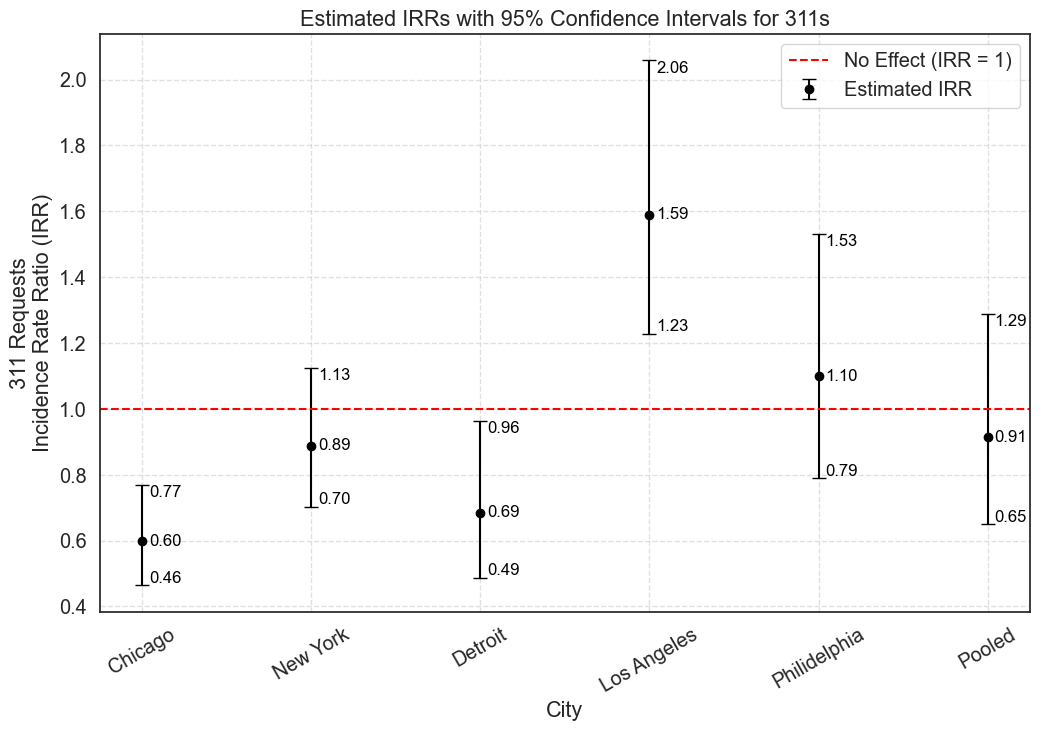

In [41]:
plot_estimates(results, '311', ylabel='311 Requests\nIncidence Rate Ratio (IRR)',
               title='Estimated IRRs with 95% Confidence Intervals for 311s')


          IRR: ----
          	0    0.583558
1    1.129323
2    0.719351
3    1.332928
4    1.001639
5    0.923282
Name: crash_coef, dtype: float64
          Errors: ----
          	[0    0.139017
1    0.202113
2    0.208086
3    0.291520
4    0.214191
5    0.235365
dtype: float64, 0    0.182491
1    0.246169
2    0.292776
3    0.373125
4    0.272452
5    0.315893
dtype: float64]
          


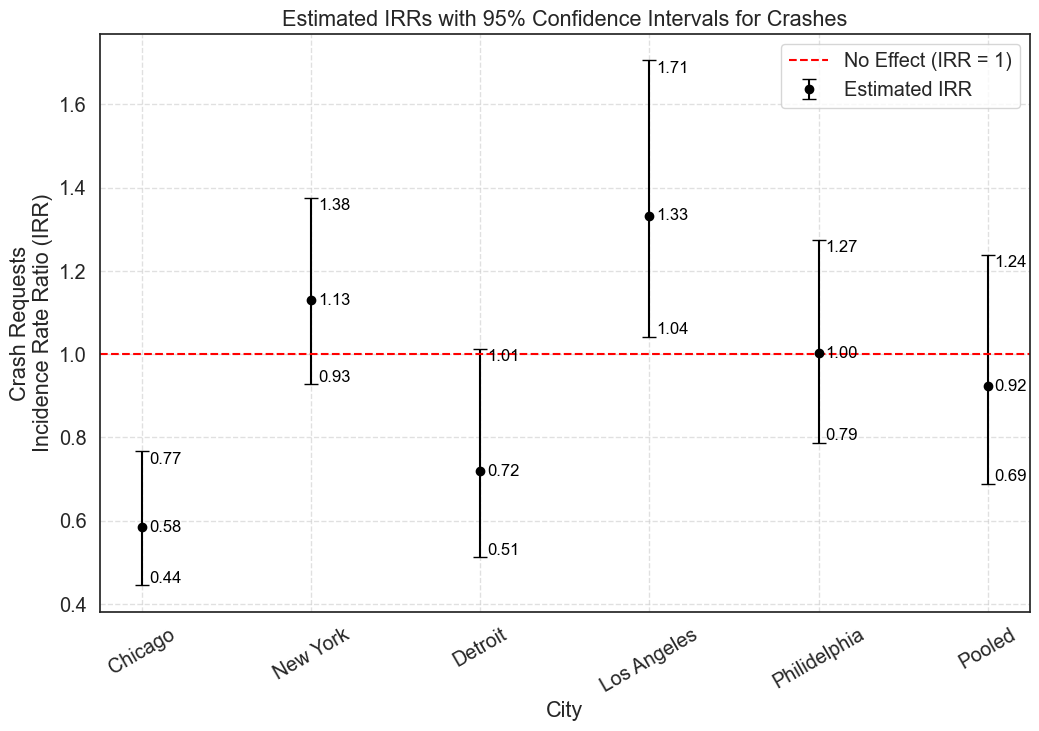

In [42]:
plot_estimates(results, 'crash', ylabel='Crash Requests\nIncidence Rate Ratio (IRR)',
               title='Estimated IRRs with 95% Confidence Intervals for Crashes')

## Collated

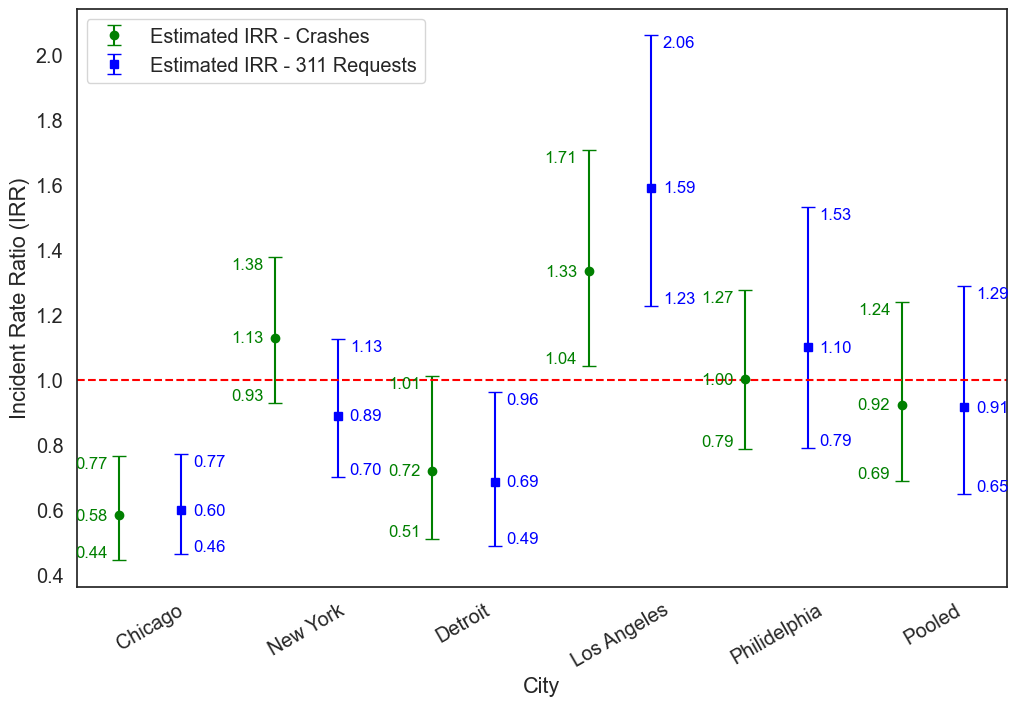

In [43]:
plot_both_estimates(results, "crash", "311", 
               "Crashes", "311 Requests", 
               "Incident Rate Ratio (IRR)", "")

## Naive Analysis

In which we just do the matching across all samples. This shouldn't work well

In [44]:
naive = pd.concat([chicago, newyork, philidelphia, losangeles, detroit], axis=0, ignore_index=True)

In [45]:
covariates_naive = feature_selection(naive)

#driving_covariates['city'].append('New York City')
#driving_covariates['covariates'].append(covariates_nyc)

naive_psmpy = make_psmpy(naive[covariates_naive + ['n_crashes', 'treatment_', 'GISJOIN']], treatment='treatment_',
                           outcome='n_crashes')

naive_psmpy.logistic_ps(balance=PROP_BALANCE)

naive_psmpy.knn_matched(matcher=PROP_MATCHER, 
                          replacement=KNN_WITH_REPLACEMENT, caliper=CALIPER,
                          drop_unmatched=DROP_UNMATCHED)

Classifier scored a 1.0 on full dataset


c:\Users\wimer\github\personal\thesis\notebooks\result_notebooks\propensity_helpers.py:98: UserWarning: Found NAs in covariates, dropping. Lost 20 observations out of 2402
  warn(f"Found NAs in covariates, dropping. Lost {old_size-new_size} observations out of {old_size}")
c:\Users\wimer\github\personal\thesis\notebooks\result_notebooks\propensity_helpers.py:102: UserWarning: Found missing outcome values. Filling with 0
  warn("Found missing outcome values. Filling with 0")
c:\Python311\Lib\site-packages\psmpy\psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatc

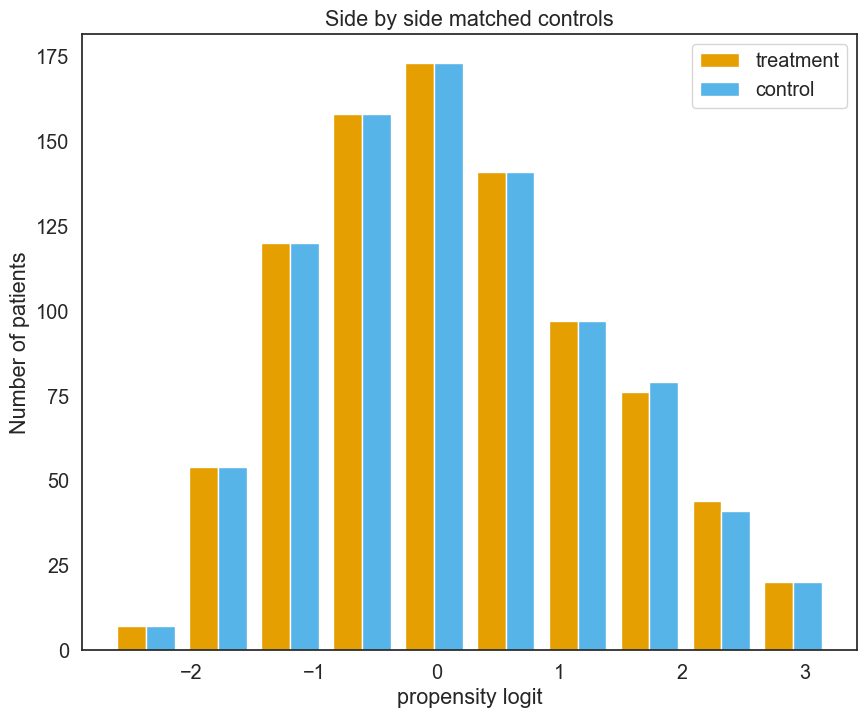

In [46]:
naive_psmpy.plot_match()

c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


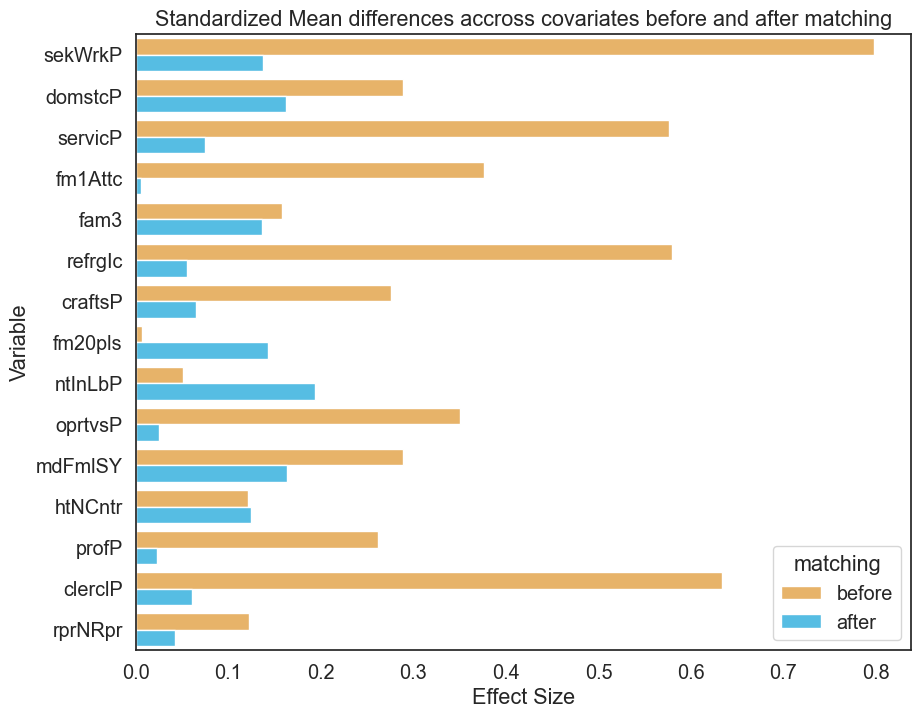

In [47]:
naive_psmpy.effect_size_plot()

In [48]:
naive_matched = retrieve_matches(naive_psmpy, naive)
naive_matched['log_exposure'] = np.log(5)

run_models_update_results(naive_matched, all_results, 'Naive')

all_results

Estimating an alpha of 2.5317993632042883 for crashes
Checking Asumptions of Negative Binomial Model for 311s:
    	Mean 311s: 1334.2815384615385
    	Variance of 311s: 9751543.424909102
    
Estimating an alpha of 5.476700320366577 for 311s
                 Generalized Linear Model Regression Results                  
Dep. Variable:              n_crashes   No. Observations:                 1324
Model:                            GLM   Df Residuals:                     1322
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9916.8
Date:                Wed, 26 Mar 2025   Deviance:                       872.04
Time:                        13:36:34   Pearson chi2:                 1.34e+03
No. Iterations:                     6   Pseudo R-squ. (CS):           0.001523
Covariance Type:            nonrobust          

{'city': ['Chicago',
  'New York',
  'Detroit',
  'Los Angeles',
  'Philidelphia',
  'Pooled',
  'Naive'],
 '311_coef': [-0.5144953028512312,
  -0.11813767059840824,
  -0.3781086515424992,
  0.4634894926561044,
  0.09447381330352905,
  -0.08919865127533816,
  0.02144025087720597],
 '311_se': [0.12900983127041088,
  0.12054779494742558,
  0.17376580706319023,
  0.13188386541146815,
  0.16932232240386835,
  0.1748072805778199,
  0.13717833407610955],
 '311_p': [6.662374951876087e-05,
  0.3270827136371298,
  0.029557732659284505,
  0.00044078839486135077,
  0.5768768193357559,
  <NA>,
  0.8758007090462276],
 'crash_coef': [-0.538611323577101,
  0.12161877420118983,
  -0.32940530543981733,
  0.28737826492319646,
  0.0016380020042344734,
  -0.07982069444314227,
  -0.13038650945466826],
 'crash_se': [0.1388276975048072,
  0.10060879100248632,
  0.17421438776620551,
  0.1259207274202303,
  0.12275254072121337,
  0.15013603646192936,
  0.09239857164097764],
 'crash_p': [0.00010458071388452409,